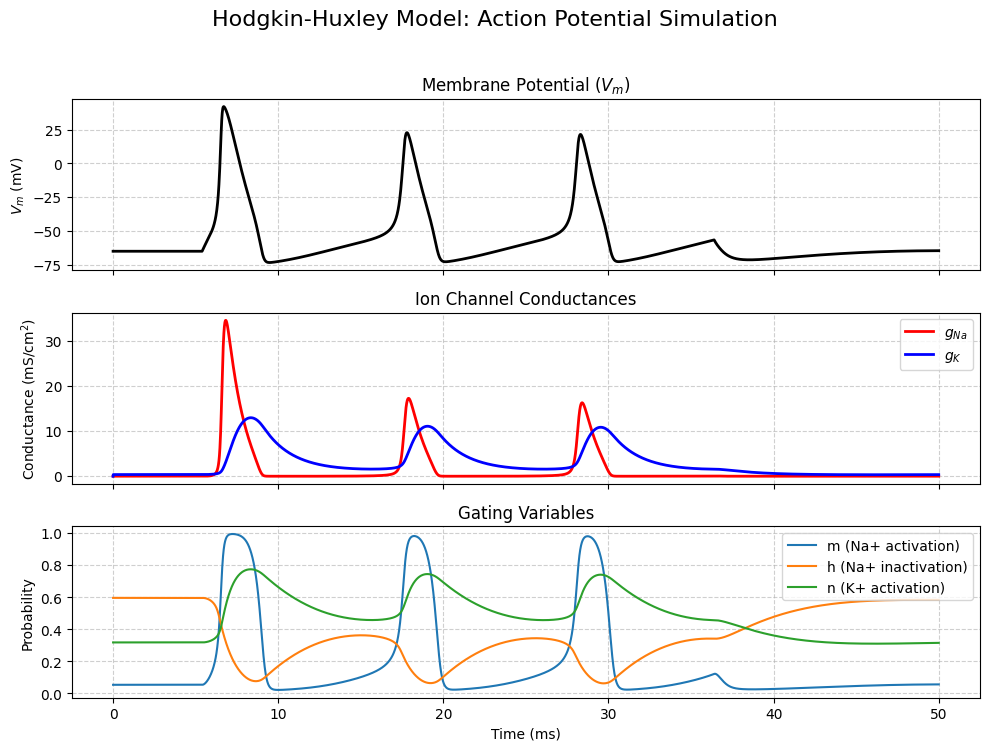

In [1]:
#!/usr/bin/env python3
"""
Enhanced Interactive Hodgkin-Huxley Action Potential Simulator with a Tkinter GUI.

This script simulates an action potential using the Hodgkin-Huxley model.
The user can interactively adjust stimulus current and temperature parameters
and see the results immediately.

The simulation solves the four coupled ordinary differential equations for:
- Vm: Membrane Potential
- m:  Na+ channel activation gate
- h:  Na+ channel inactivation gate
- n:  K+ channel activation gate
"""

import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# ------------------------------------------------------------------------------
# 1. Hodgkin-Huxley Model Equations
# ------------------------------------------------------------------------------

# --- Rate Functions for Ion Channel Gates (alpha and beta) ---
def alpha_n(V):
    if V == -55.0: return 0.1
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

def alpha_m(V):
    if V == -40.0: return 1.0
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

# ------------------------------------------------------------------------------
# 2. Main Application Class with GUI
# ------------------------------------------------------------------------------
class HodgkinHuxleyGUI:
    def __init__(self, master):
        self.master = master
        master.title("Hodgkin-Huxley Simulator")

        # --- Model & Simulation Parameters ---
        self.C_m = 1.0
        self.V_rest = -65.0
        self.gK_max = 36.0
        self.gNa_max = 120.0
        self.g_leak = 0.3
        self.E_K = -77.0
        self.E_Na = 50.0
        self.E_leak = -54.4
        self.dt = 0.01
        self.tmax = 50.0
        self.t_array = np.arange(0, self.tmax + self.dt, self.dt)
        self.Q10 = 3.0 # Temperature coefficient

        # --- Create GUI Frames ---
        main_frame = tk.Frame(master)
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        control_frame = tk.Frame(main_frame)
        control_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)
        
        plot_frame = tk.Frame(main_frame)
        plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # --- Create Interactive Controls (Sliders) ---
        slider_frame = tk.Frame(control_frame)
        slider_frame.pack(side=tk.LEFT, expand=True, fill=tk.X)
        
        self.amp_slider = self._create_slider(slider_frame, "Stim Amplitude (μA/cm²)", 0, 50, 15.0)
        self.start_slider = self._create_slider(slider_frame, "Stim Start (ms)", 0, 40, 5.0)
        self.dur_slider = self._create_slider(slider_frame, "Stim Duration (ms)", 0.1, 50, 1.0)
        self.temp_slider = self._create_slider(slider_frame, "Temperature (°C)", 0, 30, 6.3)

        # --- Create Preset Buttons ---
        preset_frame = tk.Frame(control_frame, padx=10)
        preset_frame.pack(side=tk.LEFT)
        tk.Label(preset_frame, text="Presets:").pack()
        tk.Button(preset_frame, text="Single Spike", command=self.set_single_spike).pack(fill=tk.X)
        tk.Button(preset_frame, text="Tonic Firing", command=self.set_tonic_firing).pack(fill=tk.X)

        # --- Setup Matplotlib Figure and Canvas ---
        self.fig, self.axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        # Initial plot
        self.update_plot()

    def _create_slider(self, parent, label, from_, to, initial_val):
        """Helper function to create a labeled slider with real-time updates."""
        frame = tk.Frame(parent)
        frame.pack(side=tk.LEFT, padx=10, pady=5, expand=True, fill=tk.X)
        tk.Label(frame, text=label).pack()
        slider = tk.Scale(frame, from_=from_, to=to, resolution=0.1, orient=tk.HORIZONTAL, command=self._update_on_drag)
        slider.set(initial_val)
        slider.pack(fill=tk.X, expand=True)
        return slider

    def _update_on_drag(self, _=None):
        """Callback for slider movement to update the plot."""
        self.update_plot()

    def run_simulation(self, I_stim_amplitude, stim_start, stim_duration, temp_celsius):
        """Runs the core HH simulation logic, now including temperature."""
        # Temperature factor
        phi = self.Q10**((temp_celsius - 6.3) / 10.0)

        Vm_t = np.zeros_like(self.t_array)
        gNa_t, gK_t = [np.zeros_like(self.t_array) for _ in range(2)]
        m_t, h_t, n_t = [np.zeros_like(self.t_array) for _ in range(3)]

        Vm_t[0] = self.V_rest
        m_t[0] = alpha_m(self.V_rest) / (alpha_m(self.V_rest) + beta_m(self.V_rest))
        h_t[0] = alpha_h(self.V_rest) / (alpha_h(self.V_rest) + beta_h(self.V_rest))
        n_t[0] = alpha_n(self.V_rest) / (alpha_n(self.V_rest) + beta_n(self.V_rest))

        for i in range(1, len(self.t_array)):
            t = self.t_array[i]
            Vm = Vm_t[i-1]
            m, h, n = m_t[i-1], h_t[i-1], n_t[i-1]

            gNa = self.gNa_max * (m**3) * h
            gK = self.gK_max * (n**4)
            gNa_t[i], gK_t[i] = gNa, gK

            I_Na = gNa * (Vm - self.E_Na)
            I_K = gK * (Vm - self.E_K)
            I_leak = self.g_leak * (Vm - self.E_leak)
            I_ion = I_Na + I_K + I_leak

            I_stim = I_stim_amplitude if stim_start <= t <= stim_start + stim_duration else 0.0

            dVm_dt = (I_stim - I_ion) / self.C_m
            Vm_t[i] = Vm + dVm_dt * self.dt

            dm_dt = phi * (alpha_m(Vm) * (1 - m) - beta_m(Vm) * m)
            dh_dt = phi * (alpha_h(Vm) * (1 - h) - beta_h(Vm) * h)
            dn_dt = phi * (alpha_n(Vm) * (1 - n) - beta_n(Vm) * n)
            m_t[i] = m + dm_dt * self.dt
            h_t[i] = h + dh_dt * self.dt
            n_t[i] = n + dn_dt * self.dt

        return Vm_t, gNa_t, gK_t, m_t, h_t, n_t

    def update_plot(self):
        """Gets slider values, runs simulation, and updates the plots."""
        amp = self.amp_slider.get()
        start = self.start_slider.get()
        dur = self.dur_slider.get()
        temp = self.temp_slider.get()

        Vm, gNa, gK, m, h, n = self.run_simulation(amp, start, dur, temp)

        for ax in self.axes:
            ax.clear()

        self.fig.suptitle('Hodgkin-Huxley Model: Action Potential Simulation', fontsize=16)

        # Plot 1: Membrane Potential
        self.axes[0].plot(self.t_array, Vm, 'k', linewidth=2)
        self.axes[0].set_title('Membrane Potential ($V_m$)')
        self.axes[0].set_ylabel('$V_m$ (mV)')
        self.axes[0].grid(True, linestyle='--', alpha=0.6)

        # Plot 2: Ion Channel Conductances
        self.axes[1].plot(self.t_array, gNa, 'r-', label='$g_{Na}$', linewidth=2)
        self.axes[1].plot(self.t_array, gK, 'b-', label='$g_K$', linewidth=2)
        self.axes[1].set_title('Ion Channel Conductances')
        self.axes[1].set_ylabel('Conductance (mS/cm$^2$)')
        self.axes[1].legend()
        self.axes[1].grid(True, linestyle='--', alpha=0.6)

        # Plot 3: Gating Variables
        self.axes[2].plot(self.t_array, m, label='m (Na+ activation)')
        self.axes[2].plot(self.t_array, h, label='h (Na+ inactivation)')
        self.axes[2].plot(self.t_array, n, label='n (K+ activation)')
        self.axes[2].set_title('Gating Variables')
        self.axes[2].set_ylabel('Probability')
        self.axes[2].set_xlabel('Time (ms)')
        self.axes[2].legend()
        self.axes[2].grid(True, linestyle='--', alpha=0.6)

        self.fig.tight_layout(rect=[0, 0, 1, 0.96])
        self.canvas.draw()

    def set_single_spike(self):
        """Preset for a typical single action potential."""
        self.amp_slider.set(15.0)
        self.start_slider.set(5.0)
        self.dur_slider.set(1.0)
        self.update_plot()

    def set_tonic_firing(self):
        """Preset for continuous (tonic) firing."""
        self.amp_slider.set(20.0)
        self.start_slider.set(5.0)
        self.dur_slider.set(45.0)
        self.update_plot()

# ------------------------------------------------------------------------------
# 5. Run the Application
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    root = tk.Tk()
    app = HodgkinHuxleyGUI(root)
    root.mainloop()
